# Classical modeling using bayesian inference

In this notebook we will fit some basic time series model to our data. To keep the problem simple, we will initially put our focus on just one time series

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import pystan
import arviz as az

## AR(p)

The process is written as

$$
y_t = \sum_{i=1}^p \psi_i y_{t-i} + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2)
$$

Here our parameter vector is maden by $\underline \theta = [\psi_1, \ldots, \psi_p, \sigma^2]$. We assume the following conjugate prior

$$
\begin{align*}
\underline \psi &\sim \mathcal{N}_p(\underline \mu_0, \sigma^2 C_0) \\
\sigma^2 &\sim inv\Gamma\Biggl(\frac{n_0}{2}, \frac{n_0 \sigma_0^2}{2} \Biggr)
\end{align*}
$$

In [2]:
# fit the model and run MCMC
model_code = '''
    parameters {
        real y;
    } 
    model {
        y ~ normal(0,1);
    }
'''

model = pystan.StanModel(model_code=model_code)
y = model.sampling().extract()['y']

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7a6b2a705e2b4d964db0142cb360afc4 NOW.


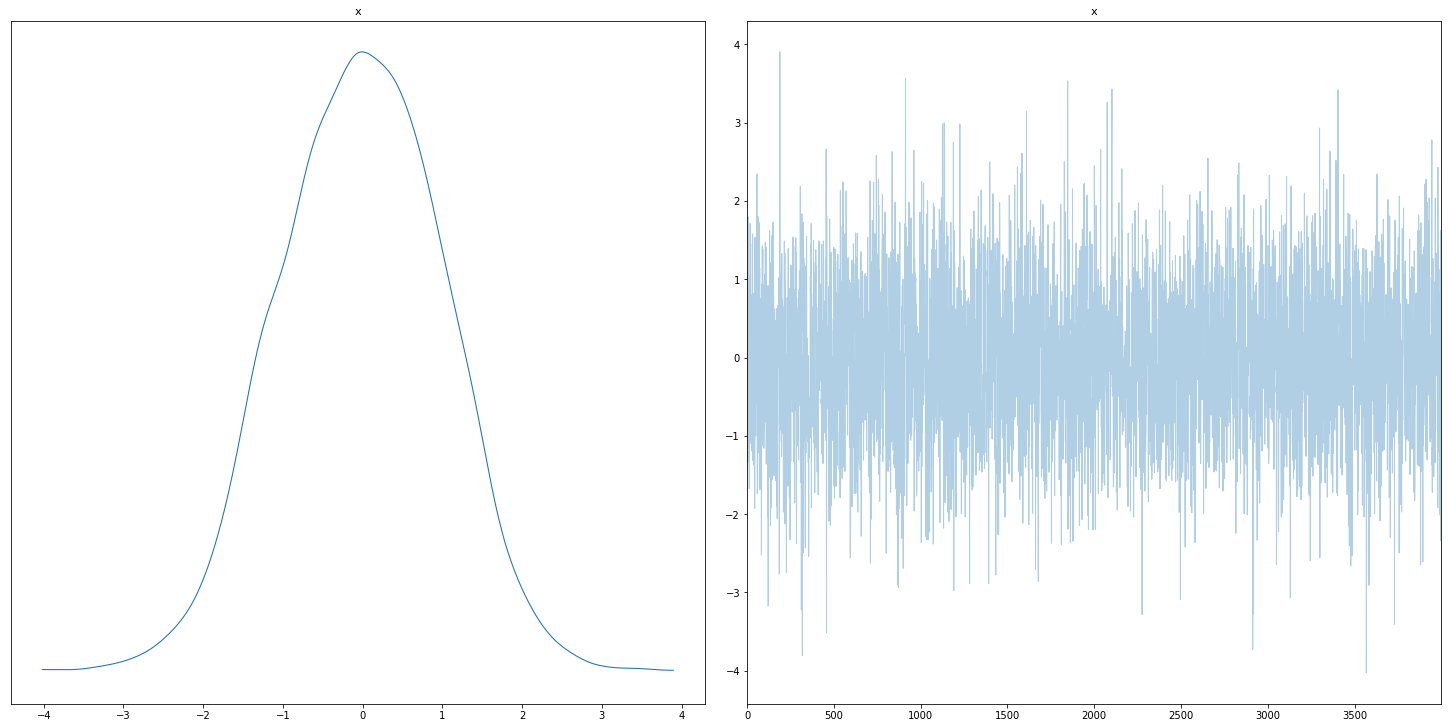

In [3]:
# plot the results
az.plot_trace(y)
plt.gcf().set_size_inches(20, 10)
plt.show()